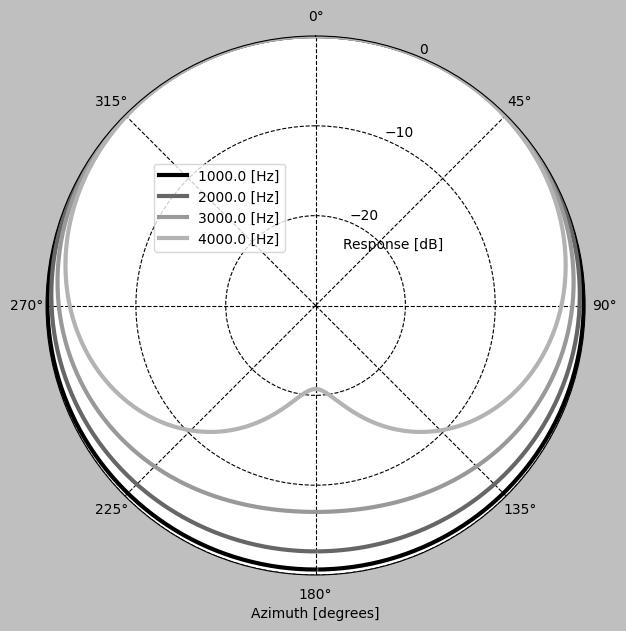

In [1]:


import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

#ステアリングベクトルを算出
#mic_position: 3 x M  dimensional ndarray [[x,y,z],[x,y,z]]
#source_position: 3x Ns dimensional ndarray [[x,y,z],[x,y,z] ]
#freqs: Nk dimensional array [f1,f2,f3...]
#sound_speed: 音速 [m/s]
#is_use_far: Farを使う場合はTrue, Nearの場合はFalse, 
#return: steering vector (Nk x Ns x M)
def calculate_steering_vector(mic_alignments,source_locations,freqs,sound_speed=340,is_use_far=False):
    #マイク数を取得
    n_channels=np.shape(mic_alignments)[1]

    #音源数を取得
    n_source=np.shape(source_locations)[1]

    if is_use_far==True:
        #音源位置を正規化
        norm_source_locations=source_locations/np.linalg.norm(source_locations,2,axis=0,keepdims=True)

        #位相を求める
        steering_phase=np.einsum('k,ism,ism->ksm',2.j*np.pi/sound_speed*freqs,norm_source_locations[...,None],mic_alignments[:,None,:])

        #ステアリングベクトルを算出
        steering_vector=1./np.sqrt(n_channels)*np.exp(steering_phase)

        return(steering_vector)

    else:

        #音源とマイクの距離を求める
        #distance: Ns x Nm
        distance=np.sqrt(np.sum(np.square(source_locations[...,None]-mic_alignments[:,None,:]),axis=0))

        #遅延時間(delay) [sec]
        delay=distance/sound_speed

        #ステアリングベクトルの位相を求める
        steering_phase=np.einsum('k,sm->ksm',-2.j*np.pi*freqs,delay)
    
        #音量の減衰
        steering_decay_ratio=1./distance

        #ステアリングベクトルを求める
        steering_vector=steering_decay_ratio[None,...]*np.exp(steering_phase)

        #大きさを1で正規化する
        steering_vector=steering_vector/np.linalg.norm(steering_vector,2,axis=2,keepdims=True)

    return(steering_vector)


#サンプリング周波数
sample_rate=16000

#フレームサイズ
N=1024

#周波数の数
Nk=N/2+1

#各ビンの周波数
freqs=np.arange(0,Nk,1)*sample_rate/N

#マイクロホンアレイのマイク配置
mic_alignments = np.array(
   [[x,0.0,0.0] for x in np.arange(-0.01,0.02,0.02)]
)

#マイクロホン数
n_channels=np.shape(mic_alignments)[0]

#音源の場所
doas=np.array(
    [[np.pi/2.,theta] for theta in np.arange(-np.pi,np.pi,1./180.*np.pi)]
    )

#音源とマイクロホンの距離
distance=1.
source_locations=np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance

#Near仮定に基づくステアリングベクトルを計算: steering_vectors(Nk x Ns x M)
near_steering_vectors=calculate_steering_vector(mic_alignments.T,source_locations,freqs,is_use_far=False)

#theta=0に最も近いステアリングベクトルを取り出す
desired_index=np.argmin(np.abs(doas[:,1]),axis=0)

#所望音のステアリングベクトル
desired_steering_vector=near_steering_vectors[:,desired_index,:]

#内積計算
directivity_pattern=np.square(np.abs(np.einsum("km,ksm->ks",np.conjugate(desired_steering_vector),near_steering_vectors)))

#スタイル
plt.style.use("grayscale")
#音声データをプロットする
fig=plt.figure(figsize=(7,7))

# plot
ax = plt.subplot(111, projection="polar")

#グラフの向き、グリッドの線種を指定
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
ax.grid(linestyle="--")

#y軸のラベル調整
ax.yaxis.labelpad = -250
ylabel=plt.ylabel("Response [dB]")
ylabel.set_position((0, 0.6))
ylabel.set_rotation(0)
plt.yticks([-20,-10,0])
plt.ylim([-30,0])

#x軸のラベル
plt.xlabel("Azimuth [degrees]")


#描画する周波数
draw_freqs=np.array([1000,2000,3000,4000])

draw_freq_list=np.argmin(np.abs(freqs[:,None]-draw_freqs[None,:]),axis=0)


for draw_freq_index in draw_freq_list:
    #周波数毎に指向特性を描画
    plt.plot(doas[:,1], 10.*np.log10(directivity_pattern[draw_freq_index,:]),lw=3,label="{} [Hz]".format(freqs[draw_freq_index]))

plt.legend(loc=(0.2,0.6))

#音声ファイルを画像として保存
plt.savefig("./directivity_pattern.png")

#画像を画面に表示
plt.show()


